In [ ]:
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/DL/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.96G/1.96G [01:30<00:00, 25.6MB/s]
100% 1.96G/1.96G [01:30<00:00, 23.3MB/s]


In [ ]:
!unzip /content/100-bird-species.zip -d /content/100-bird-species

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Defining dataset path
data_dir = '/content/100-bird-species/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'

In [ ]:
# Defining train transform and val transform along with data
train_transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

val_transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor()
])

In [ ]:
#Creating dataset
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(valid_dir,transform=val_transform)

In [ ]:
batch_size = 64
# Creating dataloader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size, shuffle=True)

In [ ]:
# Performing sanity check of the train dataloader
for i, (inputs, labels) in enumerate(train_loader):
  print(inputs.shape,labels.shape)
  break

torch.Size([64, 3, 128, 128]) torch.Size([64])


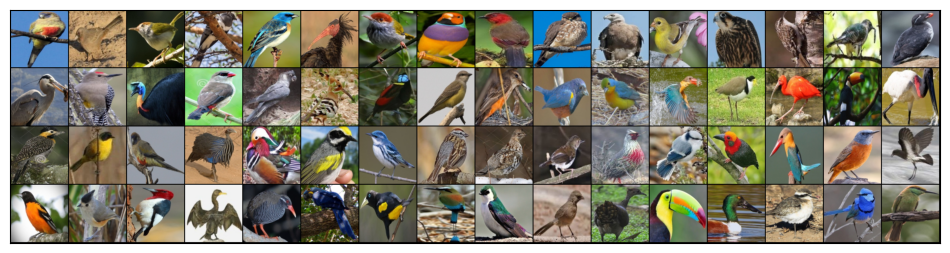

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=16).permute(1, 2, 0))
    break

show_batch(train_loader)

In [ ]:
# Defining num of classes
num_classes = len(train_dataset.classes)
print(num_classes)

525


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Pushing data to device
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # preds는 예측 결과 클래스의 인덱스
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(8192, num_classes))
                                        # nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, num_classes), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_loader)]
history

[{'val_loss': 6.264270782470703, 'val_acc': 0.00037202381645329297}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_loader, valid_loader, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00280, train_loss: 5.5526, val_loss: 3.2544, val_acc: 0.3333
Epoch [1], last_lr: 0.00760, train_loss: 2.9808, val_loss: 2.8543, val_acc: 0.4167
Epoch [2], last_lr: 0.01000, train_loss: 2.4893, val_loss: 1.8811, val_acc: 0.5897
Epoch [3], last_lr: 0.00950, train_loss: 2.1992, val_loss: 1.5249, val_acc: 0.6577
Epoch [4], last_lr: 0.00812, train_loss: 1.9620, val_loss: 1.5464, val_acc: 0.6592
Epoch [5], last_lr: 0.00611, train_loss: 1.7017, val_loss: 1.2983, val_acc: 0.7065
Epoch [6], last_lr: 0.00389, train_loss: 1.3607, val_loss: 1.0881, val_acc: 0.7359
Epoch [7], last_lr: 0.00188, train_loss: 0.9903, val_loss: 0.7278, val_acc: 0.8307
Epoch [8], last_lr: 0.00050, train_loss: 0.6417, val_loss: 0.5813, val_acc: 0.8609
Epoch [9], last_lr: 0.00000, train_loss: 0.4179, val_loss: 0.5518, val_acc: 0.8687


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

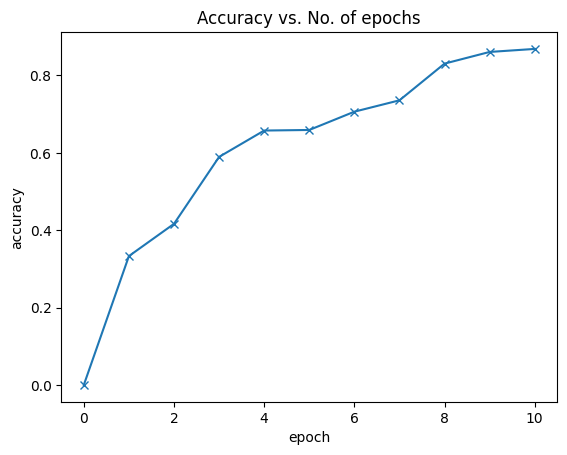

In [ ]:
plot_accuracies(history)

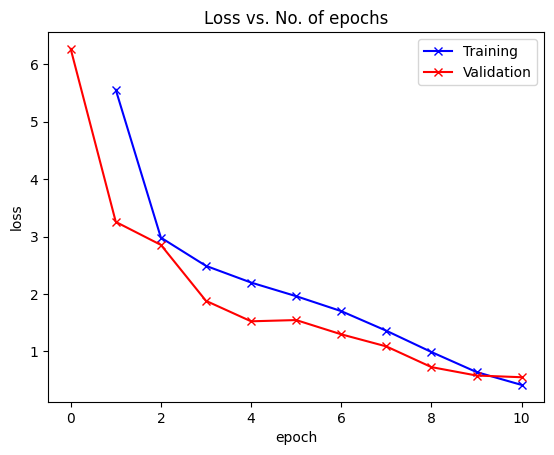

In [ ]:
plot_losses(history)

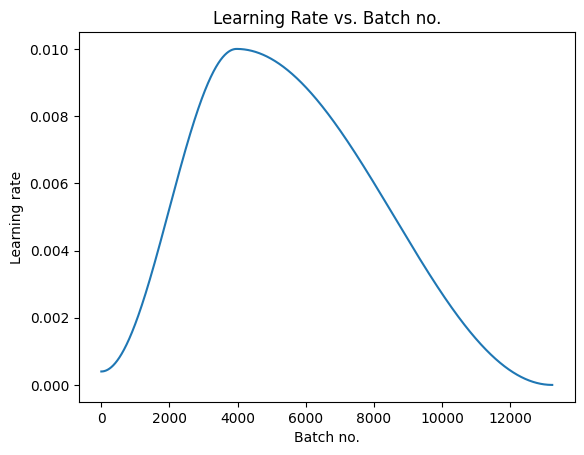

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

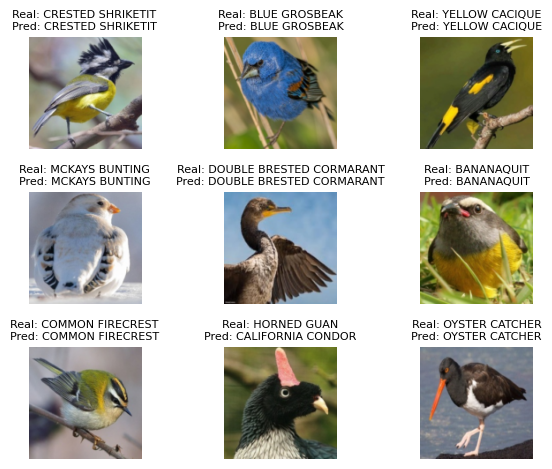

In [ ]:
random_indicies = np.random.randint(0, len(val_dataset), 9)
fig, axes = plt.subplots(nrows=3, ncols=3)

for ax, rnd_idx in zip(axes.flat, random_indicies):
    img, label = val_dataset[rnd_idx]
    title = f"Real: {val_dataset.classes[label]}\nPred: {predict_image(img, model)}"

    pil_img = torchvision.transforms.functional.to_pil_image(img)

    ax.imshow(pil_img)
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'ResNet9.pth')